In [0]:
from google.colab import files
files.upload()

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [4]:
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [5]:
!kaggle competitions download -c nlp-getting-started

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!ls

'kaggle (1).json'   kaggle.json   sample_submission.csv   train.csv
'kaggle (2).json'   sample_data   test.csv


#Importing the dataset

Importing the libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import style
style.use('ggplot')

In [0]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [9]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [10]:
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


Dropping id column 

In [0]:
train=train.drop(columns='id')
test=test.drop(columns='id')

We can check how balanced the training data is by plotting a histogram .

In [12]:
train.shape[0]

7613

In [13]:
train[train['target']==1].shape[0]

3271

In [14]:
train[train['target']==0].shape[0]

4342

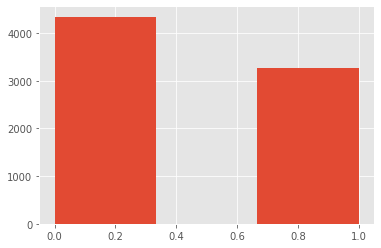

In [15]:
plt.hist(train['target'],bins=3)
plt.show()

  From the above plot we can see that the distribution is a little unbalanced

Seperating the target column from the dataset

In [16]:
y=train.iloc[:,[3]].values
y

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [17]:
train=train.drop(columns='target')
train

,keyword,location,text
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,NaN,NaN,All residents asked to 'shelter in place' are ...
3,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...
7608,NaN,NaN,Two giant cranes holding a bridge collapse int...
7609,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...
7610,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,NaN,NaN,Police investigating after an e-bike collided ...


Now we will concatenate the train and the test dataset

In [18]:
ntrain=train.shape[0]
ntest=test.shape[0]
print("Size of the training data:",ntrain)
print("Size of the testing data:",ntest)

Size of the training data: 7613
Size of the testing data: 3263


In [19]:
all_data=pd.concat([train,test],ignore_index=True)
all_data

,keyword,location,text
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,NaN,NaN,All residents asked to 'shelter in place' are ...
3,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...
10871,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
10872,NaN,NaN,Storm in RI worse than last hurricane. My city...
10873,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


#Strategy-1

###Text preprocessing 

**Here is the plan ,** first we will process the data without the location and the keyword and apply the model , afterwards we will account for the additional information given by these columns 

To make the corpus of text , we apply the following operations :


1.   We remove the punctuation marks and the numbers since they do not contribute in understanding the text.
2.   Convert text into lower case.
3. Converting all words to the stem words so that the number of words(parameters can be trimmed down).




We can also alter between a  couple of strategies to pre-process data , first we try stemming and then we try lemmatizing .

In [20]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Making a stemmer object

In [0]:
ps=PorterStemmer()

Building the corpus of text and pre-processing the data

In [22]:
corpus=[]
for i in range(0,ntrain+ntest):
	dis=re.sub(r'https?:\/\/.*[\r\n]*', '',all_data['text'][i])  #removing hyperlinks
	dis=re.sub(r'http?:\/\/.*[\r\n]*', '',dis) #removing hyperlinks
	#dis=re.sub(r'\@[a-zA-Z0-9]\w+'," ",dis) # removing account mentions actually decreases the accuracy of the model 
	dis=re.sub('[^a-zA-Z]'," ",dis) #removing punctuation marks and numbers
	dis=dis.lower() # converting into lower case
	dis=dis.split() # splitting 
	dis=[ps.stem(word) for word in dis if not word in set(stopwords.words("english"))]  #stemming the words to trim down the number of words
	dis=' '.join(dis)
	corpus.append(dis)
 
print(corpus)

['deed reason earthquak may allah forgiv us', 'forest fire near la rong sask canada', 'resid ask shelter place notifi offic evacu shelter place order expect', 'peopl receiv wildfir evacu order california', 'got sent photo rubi alaska smoke wildfir pour school', 'rockyfir updat california hwi close direct due lake counti fire cafir wildfir', 'flood disast heavi rain caus flash flood street manit colorado spring area', 'top hill see fire wood', 'emerg evacu happen build across street', 'afraid tornado come area', 'three peopl die heat wave far', 'haha south tampa get flood hah wait second live south tampa gonna gonna fvck flood', 'rain flood florida tampabay tampa day lost count', 'flood bago myanmar arriv bago', 'damag school bu multi car crash break', 'man', 'love fruit', 'summer love', 'car fast', 'goooooooaaaaaal', 'ridicul', 'london cool', 'love ski', 'wonder day', 'looooool', 'way eat shit', 'nyc last week', 'love girlfriend', 'cooool', 'like pasta', 'end', 'bbcmtd wholesal market 

In [23]:
len(corpus)

10876

In [24]:
corpus[63]

'navista steve fire someth els california tinderbox clown set hood ablaz news'

Now we create a bag of words model from the corpus of text that can be used for classification of the text.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=15000)
X=cv.fit_transform(corpus).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [26]:
X.shape

(10876, 15000)

In [27]:
from pandas import DataFrame
df=pd.DataFrame(X,columns=cv.get_feature_names())
df

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aac,aal,aamir,aan,aannnnd,aapatwork,aar,aaron,aarongoodwin,aaronkearneyau,aaronthefm,aashiqui,ab,aba,abandon,abandonedp,abba,abbandon,abbog,abbott,abbss,abbswinston,abbyairshow,abbydphillip,abc,abcfmelissajoey,abcnetwork,abcnew,abcnorio,abdul,abe,abella,aberdeen,aberdeenfanpag,aberdeenfc,...,zepp,zergel,zero,zeroedg,zerohedg,zhejiang,zhenghxn,zicac,zimbabw,zimmer,zimmerman,zion,zionism,zionist,zip,ziphimup,zipper,zippolin,zirngast,ziuw,zix,zjwhitman,zmne,zodiac,zojadelin,zomatoau,zombi,zone,zonewolf,zoom,zotar,zoui,zouma,zourryart,zrnf,zuma,zumiez,zurich,zvch,zxatheti
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10872,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10873,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10874,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


###Exploratory Data Analysis

Getting the top words 30 words for each tweet 

In [28]:
top_dict = {}
for c in df.columns:
    top = df[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'aa': [(3068, 1),
  (7591, 1),
  (521, 1),
  (10875, 0),
  (3621, 0),
  (3628, 0),
  (3627, 0),
  (3626, 0),
  (3625, 0),
  (3624, 0),
  (3623, 0),
  (3622, 0),
  (3620, 0),
  (3630, 0),
  (3619, 0),
  (3618, 0),
  (3617, 0),
  (3616, 0),
  (3615, 0),
  (3614, 0),
  (3613, 0),
  (3612, 0),
  (3629, 0),
  (3631, 0),
  (3610, 0),
  (3632, 0),
  (3649, 0),
  (3648, 0),
  (3647, 0),
  (3646, 0)],
 'aaaa': [(6014, 1),
  (10875, 0),
  (3622, 0),
  (3629, 0),
  (3628, 0),
  (3627, 0),
  (3626, 0),
  (3625, 0),
  (3624, 0),
  (3623, 0),
  (3621, 0),
  (3631, 0),
  (3620, 0),
  (3619, 0),
  (3618, 0),
  (3617, 0),
  (3616, 0),
  (3615, 0),
  (3614, 0),
  (3613, 0),
  (3630, 0),
  (3632, 0),
  (3611, 0),
  (3633, 0),
  (3650, 0),
  (3649, 0),
  (3648, 0),
  (3647, 0),
  (3646, 0),
  (3645, 0)],
 'aaaaaaallll': [(2738, 1),
  (10875, 0),
  (3631, 0),
  (3629, 0),
  (3628, 0),
  (3627, 0),
  (3626, 0),
  (3625, 0),
  (3624, 0),
  (3623, 0),
  (3622, 0),
  (3621, 0),
  (3620, 0),
  (3619, 0),
  (36

Finding the most common words used in the tweets

In [29]:
bag_of_words=cv.fit_transform(corpus) # converts the corpus into a bag of words model (sparse matrix)
sum_of_words=bag_of_words.sum(axis=0) # summing all the ones in a column , getting the number of times each word is used
words_freq=[(word,sum_of_words[0,idx])for word,idx in cv.vocabulary_.items()] #calculating words frequency 
words_freq=sorted(words_freq,key=lambda x:x[1],reverse=True)
words_freq[:200]

[('like', 585),
 ('fire', 525),
 ('amp', 481),
 ('get', 451),
 ('bomb', 338),
 ('new', 316),
 ('one', 295),
 ('go', 294),
 ('peopl', 284),
 ('burn', 257),
 ('news', 256),
 ('time', 252),
 ('year', 250),
 ('kill', 245),
 ('attack', 237),
 ('emerg', 231),
 ('flood', 230),
 ('disast', 223),
 ('crash', 222),
 ('video', 218),
 ('build', 216),
 ('would', 214),
 ('say', 206),
 ('bodi', 204),
 ('day', 200),
 ('polic', 199),
 ('love', 198),
 ('make', 193),
 ('look', 191),
 ('watch', 187),
 ('home', 185),
 ('storm', 185),
 ('still', 181),
 ('fatal', 179),
 ('train', 177),
 ('famili', 176),
 ('suicid', 176),
 ('see', 174),
 ('live', 174),
 ('know', 170),
 ('first', 169),
 ('us', 168),
 ('evacu', 168),
 ('come', 168),
 ('collaps', 167),
 ('scream', 164),
 ('got', 162),
 ('back', 162),
 ('bag', 161),
 ('take', 160),
 ('california', 158),
 ('car', 157),
 ('death', 156),
 ('think', 155),
 ('world', 155),
 ('rt', 154),
 ('want', 154),
 ('man', 153),
 ('two', 153),
 ('derail', 153),
 ('drown', 152),
 (

In [32]:
cv.vocabulary_.items() # it shows the word and the column number in the sparse matrix (word,column number)

dict_items([('deed', 3247), ('reason', 10523), ('earthquak', 3910), ('may', 8093), ('allah', 381), ('forgiv', 4851), ('us', 13924), ('forest', 4845), ('fire', 4682), ('near', 8647), ('la', 7445), ('rong', 10989), ('sask', 11261), ('canada', 2056), ('resid', 10740), ('ask', 779), ('shelter', 11629), ('place', 9842), ('notifi', 8944), ('offic', 9104), ('evacu', 4309), ('order', 9288), ('expect', 4378), ('peopl', 9651), ('receiv', 10544), ('wildfir', 14538), ('california', 2013), ('got', 5398), ('sent', 11484), ('photo', 9753), ('rubi', 11078), ('alaska', 316), ('smoke', 11957), ('pour', 10001), ('school', 11341), ('rockyfir', 10948), ('updat', 13891), ('hwi', 6219), ('close', 2534), ('direct', 3485), ('due', 3832), ('lake', 7470), ('counti', 2802), ('cafir', 1981), ('flood', 4759), ('disast', 3503), ('heavi', 5828), ('rain', 10405), ('caus', 2212), ('flash', 4728), ('street', 12466), ('colorado', 2584), ('spring', 12244), ('area', 683), ('top', 13385), ('hill', 5940), ('see', 11439), ('w

We can add some of the most used words to stop words

In [0]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
add_stop_words=["like","us","said","one","go","may","ask","say","got","let","even","lol","see","would","come","get"]
stop_words=text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [47]:
cv=CountVectorizer(stop_words=stop_words,max_features=15000)
X=cv.fit_transform(corpus).toarray()
df_cleaned=pd.DataFrame(X,columns=cv.get_feature_names())
df_cleaned

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aac,aal,aamir,aan,aannnnd,aapatwork,aar,aaron,aarongoodwin,aaronkearneyau,aaronthefm,aashiqui,ab,aba,abandon,abandonedp,abba,abbandon,abbog,abbott,abbss,abbswinston,abbyairshow,abbydphillip,abc,abcfmelissajoey,abcnetwork,abcnew,abcnorio,abdul,abe,abella,aberdeen,aberdeenfanpag,aberdeenfc,...,zepp,zergel,zero,zeroedg,zerohedg,zhejiang,zhenghxn,zicac,zimbabw,zimmer,zimmerman,zion,zionism,zionist,zip,ziphimup,zipper,zippolin,zirngast,ziuw,zix,zjwhitman,zmne,zodiac,zojadelin,zomatoau,zombi,zone,zonewolf,zoom,zotar,zoui,zouma,zourryart,zrnf,zuma,zumiez,zurich,zvch,zxatheti
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10872,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10873,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10874,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


###Preparing data for applying classification model

Seperating training set and the test(PREDICTION) set

In [0]:
X1=X[:ntrain,:]
X_pred=X[ntrain:,:]

In [49]:
X1.shape

(7613, 15000)

In [50]:
X_pred.shape

(3263, 15000)

Splitting the training data into training set and test set

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X1,y,test_size=0.2,random_state=0)

Since the dataset is imbalanced , we use SMOTE to make it balanced hoping it would increase the accuracy.

**SMOTE refers to Synthetic minority oversampling <br>
What happens under this technique of sampling/balancing?** <br>

Take the difference between the feature vector (sample) under
consideration and its nearest neighbour. Multiply this difference
by a random number between 0 and 1, and add it to the feature
vector under consideration. This causes the selection of a random
point along the line segment between two specific features. This
approach effectively forces the decision region of the minority class
to become more general.


But here we observe that oversampling reduced accuracy .

In [0]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
oversampler=SMOTE(random_state=0)
#X_train,y_train=oversampler.fit_sample(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Applying Random Forest 

Lets try Random Forest model

In [52]:
from sklearn.ensemble import RandomForestClassifier
clf1=RandomForestClassifier(n_estimators=1000,criterion='entropy',random_state=1,n_jobs=-1,oob_score=True)
clf1.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

###Making predictions and checking accuracy

Making predictions 

In [0]:
y_pred=clf1.predict(X_test)

Checking confusion matrix

In [54]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
pred_true=cm[0,0]+cm[1,1]
pred_false=cm[0,1]+cm[1,0]
print("correct predictions:"+str(pred_true))
print("incorrect predictions:"+str(pred_false))

correct predictions:1196
incorrect predictions:327


In [55]:
cm

array([[778, 108],
       [219, 418]])

###Applying Naive Bayes 

Applying Naives bayes model to classify the text

In [0]:
from sklearn.naive_bayes import GaussianNB
clf=GaussianNB()

In [57]:
clf.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

###Checking accuracy

In [0]:
y_pred=clf.predict(X_test)

Checking confusion matrix

In [59]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
pred_true=cm[0,0]+cm[1,1]
pred_false=cm[0,1]+cm[1,0]
print("correct predictions:"+str(pred_true))
print("incorrect predictions:"+str(pred_false))

correct predictions:921
incorrect predictions:602


In [60]:
cm

array([[396, 490],
       [112, 525]])

**We observe that  naive bayes has much less accuracy then RF**

#Strategy -2

In this strategy instead of stemming we will lemmatize all the text and also we will use the additional information in the dataset like the keyword and the location . As it would be to complex to make a model that includes location as a parameter let us just try including keyword.

###Text Preprocessing 

In [21]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Making a lemmatizer object

In [0]:
lm=WordNetLemmatizer()

Building the corpus of text and pre-processing the data

In [24]:
corpus=[]
for i in range(0,ntrain+ntest):
	dis=re.sub(r'https?:\/\/.*[\r\n]*', '',all_data['text'][i])  #removing hyperlinks
	dis=re.sub(r'http?:\/\/.*[\r\n]*', '',dis) #removing hyperlinks
	#dis=re.sub(r'\@[a-zA-Z0-9]\w+'," ",dis) # removing account mentions actually decreases the accuracy of the model 
	dis=re.sub('[^a-zA-Z]'," ",dis) #removing punctuation marks and numbers
	dis=dis.lower() # converting into lower case
	dis=dis.split() # splitting 
	dis=[lm.lemmatize(word) for word in dis if not word in set(stopwords.words("english"))]  #lemmatizing the words to trim down the number of words
	dis=' '.join(dis)
	corpus.append(dis)
 
print(corpus)

['deed reason earthquake may allah forgive u', 'forest fire near la ronge sask canada', 'resident asked shelter place notified officer evacuation shelter place order expected', 'people receive wildfire evacuation order california', 'got sent photo ruby alaska smoke wildfire pours school', 'rockyfire update california hwy closed direction due lake county fire cafire wildfire', 'flood disaster heavy rain cause flash flooding street manitou colorado spring area', 'top hill see fire wood', 'emergency evacuation happening building across street', 'afraid tornado coming area', 'three people died heat wave far', 'haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding', 'raining flooding florida tampabay tampa day lost count', 'flood bago myanmar arrived bago', 'damage school bus multi car crash breaking', 'man', 'love fruit', 'summer lovely', 'car fast', 'goooooooaaaaaal', 'ridiculous', 'london cool', 'love skiing', 'wonderful day', 'looooool', 'way eat sh

In [25]:
len(corpus)

10876

Now we create a bag of words model from the corpus of text that can be used for classification of the text.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=15000,stop_words=stop_words)
X=cv.fit_transform(corpus).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
X.shape

(10876, 15000)

In [28]:
from pandas import DataFrame
df=pd.DataFrame(X,columns=cv.get_feature_names())
df

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aace,aal,aamir,aan,aannnnd,aapatwork,aar,aaron,aarongoodwin,aaronkearneyaus,aaronthefm,aashiqui,ab,aba,abandon,abandoned,abandonedpics,abandoning,abb,abba,abbandoned,abbog,abbott,abbswinston,abbyairshow,abbydphillip,abc,abcfmelissajoey,abcnetwork,abcnews,abcnorio,abdul,abe,abella,aberdeen,...,zepp,zergele,zero,zeroedge,zerohedge,zhejiang,zhenghxn,zicac,zimbabwe,zimmer,zimmerman,zion,zionism,zionist,zip,ziphimup,zipped,zipper,zippoline,zirngast,ziuw,zix,zjwhitman,zmne,zodiac,zojadelin,zomatoaus,zombie,zone,zonewolf,zoom,zotar,zouis,zouma,zourryart,zrnf,zuma,zumiez,zurich,zvch
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10872,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10873,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10874,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we will concatenate the keyword column with the above dataframe ,but first we have to deal with missing values in the keyword column 

In [0]:
all_data['keyword'].fillna('No-keyword', inplace = True)

In [30]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   10876 non-null  object
 1   location  7238 non-null   object
 2   text      10876 non-null  object
dtypes: object(3)
memory usage: 255.0+ KB


In [0]:
keyword_df=pd.get_dummies(all_data['keyword'],drop_first=True)

In [32]:
keyword_df

,ablaze,accident,aftershock,airplane%20accident,ambulance,annihilated,annihilation,apocalypse,armageddon,army,arson,arsonist,attack,attacked,avalanche,battle,bioterror,bioterrorism,blaze,blazing,bleeding,blew%20up,blight,blizzard,blood,bloody,blown%20up,body%20bag,body%20bagging,body%20bags,bomb,bombed,bombing,bridge%20collapse,buildings%20burning,buildings%20on%20fire,burned,burning,burning%20buildings,bush%20fires,...,snowstorm,storm,stretcher,structural%20failure,suicide%20bomb,suicide%20bomber,suicide%20bombing,sunk,survive,survived,survivors,terrorism,terrorist,threat,thunder,thunderstorm,tornado,tragedy,trapped,trauma,traumatised,trouble,tsunami,twister,typhoon,upheaval,violent%20storm,volcano,war%20zone,weapon,weapons,whirlwind,wild%20fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10872,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10873,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10874,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Concatenating the datasets

In [0]:
main_data=pd.concat([keyword_df,df],axis=1)

In [36]:
main_data

,ablaze,accident,aftershock,airplane%20accident,ambulance,annihilated,annihilation,apocalypse,armageddon,army,arson,arsonist,attack,attacked,avalanche,battle,bioterror,bioterrorism,blaze,blazing,bleeding,blew%20up,blight,blizzard,blood,bloody,blown%20up,body%20bag,body%20bagging,body%20bags,bomb,bombed,bombing,bridge%20collapse,buildings%20burning,buildings%20on%20fire,burned,burning,burning%20buildings,bush%20fires,...,zepp,zergele,zero,zeroedge,zerohedge,zhejiang,zhenghxn,zicac,zimbabwe,zimmer,zimmerman,zion,zionism,zionist,zip,ziphimup,zipped,zipper,zippoline,zirngast,ziuw,zix,zjwhitman,zmne,zodiac,zojadelin,zomatoaus,zombie,zone,zonewolf,zoom,zotar,zouis,zouma,zourryart,zrnf,zuma,zumiez,zurich,zvch
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10872,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10873,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10874,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
X=main_data.iloc[:,:].values

###Preparing data for applying classification model

Seperating training set and the test(PREDICTION) set

In [0]:
X1=X[:ntrain,:]
X_pred=X[ntrain:,:]

In [38]:
X1.shape

(7613, 15221)

In [39]:
X_pred.shape

(3263, 15221)

Splitting the training data into training set and test set

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X1,y,test_size=0.2,random_state=0)

### Applying Random Forest 

Lets try Random Forest model

In [41]:
from sklearn.ensemble import RandomForestClassifier
clf1=RandomForestClassifier(n_estimators=2000,criterion='entropy',random_state=1,n_jobs=-1,oob_score=True)
clf1.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

###Making predictions and checking accuracy

Making predictions 

In [0]:
y_pred=clf1.predict(X_test)

Checking confusion matrix

In [43]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
pred_true=cm[0,0]+cm[1,1]
pred_false=cm[0,1]+cm[1,0]
print("correct predictions:"+str(pred_true))
print("incorrect predictions:"+str(pred_false))

correct predictions:1204
incorrect predictions:319


In [44]:
cm

array([[791,  95],
       [224, 413]])

### Using  Precision,Recall and F1 score 

**Precision:** It is the fraction of the relevant instances among the retreived instances .

**Recall:** It is the fraction of the total amount of relevant instances that were actually retreived .<br>

In simple terms, high precision means that an algorithm returned substantially more relevant results than irrelevant ones, while high recall means that an algorithm returned most of the relevant results.

**F1 score:**It is also called the F Score or the F Measure. Put another way, the F1 score conveys the balance between the precision and the recall.

In [0]:
TN=cm[0,0] # true negative 
TP=cm[1,1] # true postives
FP=cm[0,1] # false positive
FN=cm[1,0] #false negative
Accuracy = (TP + TN) / (TP + TN + FP + FN)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_Score = 2 * Precision * Recall / (Precision + Recall)

Precision

In [51]:
Precision

0.812992125984252

Recall

In [50]:
Recall

0.6483516483516484

F1 Score

In [52]:
F1_Score

0.7213973799126637

Accuracy

In [53]:
Accuracy

0.7905449770190414

###Submission

In [0]:
y_pred=clf1.predict(X_pred)

In [0]:
read=pd.read_csv("sample_submission.csv")

In [0]:
read['target'] = y_pred
read.to_csv('submission.csv',index=False)

In [61]:
read

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
